# Donkey Car Attempt

My attempts to build a CNN from scratch are hitting walls. I am going to try out a model suggested on the [Donkey Car Webpage](https://docs.donkeycar.com/dev_guide/model/), to see if it's any better.

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import time

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from keras_tuner import BayesianOptimization, Hyperband, HyperModel

from os.path import exists

from tensorflow import keras
from tensorflow.keras.backend import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, Convolution2D
from tensorflow.keras.metrics import MAE, MSE, RootMeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2021-11-14 20:19:02.016016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
## Constants
working_date = '11_12_2021'
working_time = '19_28_18'

model_history_file = '../models/model_history.csv'

In [3]:
## Directories
data_directory = f'../data/{working_date}/{working_time}'
model_directory = f'../models/{working_date}/{working_time}'

## File paths
cam_input_dataset_file = f'{data_directory}/X_img.npy'
imu_input_dataset_file = f'{data_directory}/X_imu.pkl'
scaled_imu_input_dataset_file = f'{data_directory}/X_imu_sc.npy'
target_dataset_file = f'{data_directory}/y.npy'

In [4]:
## Make sure model history exists
if not exists(model_history_file):
    model_history = pd.DataFrame(columns=['model', 'history', 
                                          'r2_score', 'mae_score',
                                          'mse_score', 'rmse_score'])
else:
    model_history = pd.read_csv(model_history_file, index_col=0)

## Data

### Load Datasets

In [5]:
## Load the datasets
X_cam = np.load(cam_input_dataset_file)
X_imu = pd.read_pickle(imu_input_dataset_file).to_numpy()
X_imu_sc = np.load(scaled_imu_input_dataset_file)
y = np.load(target_dataset_file)

In [6]:
## Split for dual output
y_steering = y[:, 0]
y_throttle = y[:, 1]

In [7]:
X_imu_sc.shape

(115052, 9)

In [8]:
X_cam.shape

(115052, 64, 64, 1)

### Train-Test Split

In [9]:
datasets = train_test_split(X_cam, X_imu_sc, y_steering, y_throttle, test_size=0.1, random_state=0)

X_cam_train = datasets[0]
X_cam_test = datasets[1]
X_imu_train = datasets[2]
X_imu_test = datasets[3]
y_st_train = datasets[4]
y_st_test = datasets[5]
y_th_train = datasets[6]
y_th_test = datasets[7]

## Model

### Create Framework

In [16]:
# https://docs.donkeycar.com/dev_guide/model/
# https://github.com/autorope/donkeycar/blob/dev/donkeycar/parts/keras.py

def create_model(cam_input_shape):
    drop = 0.2
    img_in = Input(shape=cam_input_shape, name='img_in') 
    x = img_in
    x = conv2d(24, 5, 2, 1)(x)
    x = Dropout(drop)(x)
    x = conv2d(32, 5, 2, 2)(x)
    x = Dropout(drop)(x)
    x = conv2d(64, 5, 2, 3)(x)
    x = Dropout(drop)(x)
    x = conv2d(64, 3, 1, 4)(x)
    x = Dropout(drop)(x)
    x = conv2d(64, 3, 1, 5)(x)
    x = Dropout(drop)(x)
    x = Flatten(name='flattened')(x)
    x = Dense(100, activation='relu', name='dense_1')(x)
    x = Dropout(drop)(x)
    x = Dense(50, activation='relu', name='dense_2')(x)
    x = Dropout(drop)(x)
    # up to here, this is the standard linear model, now we add the
    # sensor data to it
    # sensor_in = Input(num_sensors, name='sensor_in')
    # y = sensor_in
    # z = concatenate([x, y])
    # # here we add two more dense layers
    # z = Dense(50, activation='relu', name='dense_3')(z)
    # z = Dropout(drop)(z)
    # z = Dense(50, activation='relu', name='dense_4')(z)
    # z = Dropout(drop)(z)
    # two outputs for angle and throttle
    outputs = [
        Dense(1, activation='linear', name='steering_outputs')(x),
        Dense(1, activation='linear', name='throttle_outputs')(x)
    ]
    # combined output
    # outputs = Dense(2, activation='linear', name='combined_outputs')(z)

    # the model needs to specify the additional input here
    model = Model(inputs=img_in, outputs=outputs)
    return model


def conv2d(filters, kernel, strides, layer_num, activation='relu'):
    """
    Helper function to create a standard valid-padded convolutional layer
    with square kernel and strides and unified naming convention
    :param filters:     channel dimension of the layer
    :param kernel:      creates (kernel, kernel) kernel matrix dimension
    :param strides:     creates (strides, strides) stride
    :param layer_num:   used in labelling the layer
    :param activation:  activation, defaults to relu
    :return:            tf.keras Convolution2D layer
    """
    return Convolution2D(filters=filters,
                         kernel_size=(kernel, kernel),
                         strides=(strides, strides),
                         activation=activation,
                         name='conv2d_' + str(layer_num))

In [17]:
cam_input_shape = X_cam_train[0].shape
num_imu_sensors = X_imu_train.shape[1]

In [18]:
cam_input_shape

(64, 64, 1)

In [19]:
num_imu_sensors

9

In [20]:
model = create_model(cam_input_shape)
model.compile(loss='mse', optimizer='adam', metrics=['mae', RootMeanSquaredError()])

### Fit

In [21]:
stop_early = EarlyStopping(patience=5)

In [22]:
# Separate Outputs
y_train = (y_st_train, y_th_train)
y_test = (y_st_test, y_th_test)

In [23]:
# Put y back together again. Change of plans
# y_train = np.array((y_st_train, y_th_train)).T
# y_test = np.array((y_st_test, y_th_test)).T

In [24]:
## Fit the best model
results = model.fit(
    x=X_cam_train,
    y=y_train,
    batch_size=32, 
    epochs=500, 
    callbacks=[stop_early],
    validation_data=(X_cam_test, y_test)
)

2021-11-14 20:19:59.184361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1696497664 exceeds 10% of free system memory.
2021-11-14 20:19:59.948414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-14 20:19:59.966088: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3405885000 Hz


Epoch 1/500


2021-11-14 20:20:00.648098: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-14 20:20:00.783896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-14 20:20:01.337587: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-14 20:20:01.404981: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


3236/3236 [==============================] - 44s 11ms/step - loss: 0.1661 - steering_outputs_loss: 0.0512 - throttle_outputs_loss: 0.1149 - steering_outputs_mae: 0.1623 - steering_outputs_root_mean_squared_error: 0.2203 - throttle_outputs_mae: 0.2307 - throttle_outputs_root_mean_squared_error: 0.3337 - val_loss: 0.0631 - val_steering_outputs_loss: 0.0137 - val_throttle_outputs_loss: 0.0494 - val_steering_outputs_mae: 0.0790 - val_steering_outputs_root_mean_squared_error: 0.1169 - val_throttle_outputs_mae: 0.0937 - val_throttle_outputs_root_mean_squared_error: 0.2223
Epoch 2/500
3236/3236 [==============================] - 22s 7ms/step - loss: 0.0789 - steering_outputs_loss: 0.0217 - throttle_outputs_loss: 0.0572 - steering_outputs_mae: 0.1070 - steering_outputs_root_mean_squared_error: 0.1472 - throttle_outputs_mae: 0.1362 - throttle_outputs_root_mean_squared_error: 0.2391 - val_loss: 0.0576 - val_steering_outputs_loss: 0.0131 - val_throttle_outputs_loss: 0.0445 - val_steering_outputs_

In [25]:
# plt.plot(results.history['loss'], label = 'Training Loss')
# plt.plot(results.history['val_loss'], label = 'Testing Loss')
# plt.legend();

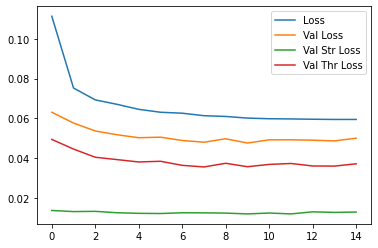

In [26]:
plt.plot(results.history['loss'], label = 'Loss')
plt.plot(results.history['val_loss'], label = 'Val Loss')
plt.plot(results.history['val_steering_outputs_loss'], label = 'Val Str Loss')
plt.plot(results.history['val_throttle_outputs_loss'], label = 'Val Thr Loss')


plt.legend();

In [27]:
results.history.keys()

dict_keys(['loss', 'steering_outputs_loss', 'throttle_outputs_loss', 'steering_outputs_mae', 'steering_outputs_root_mean_squared_error', 'throttle_outputs_mae', 'throttle_outputs_root_mean_squared_error', 'val_loss', 'val_steering_outputs_loss', 'val_throttle_outputs_loss', 'val_steering_outputs_mae', 'val_steering_outputs_root_mean_squared_error', 'val_throttle_outputs_mae', 'val_throttle_outputs_root_mean_squared_error'])

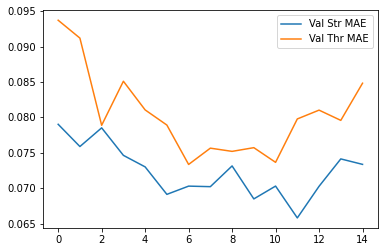

In [28]:
# plt.plot(results.history['mae'], label = 'MAE')
# plt.plot(results.history['val_mae'], label = 'Val MAE')
plt.plot(results.history['val_steering_outputs_mae'], label = 'Val Str MAE')
plt.plot(results.history['val_throttle_outputs_mae'], label = 'Val Thr MAE')
plt.legend();

## Save model

In [29]:
model_index = max(0, model_history.index.max() + 1)
model_path = f'{model_directory}/model_{model_index}.h5'

history_dictionary = {
    'model': model_path,
    'history': results.history,
    # 'r2_score': metrics.r2_score(y_test, preds),
    # 'mae_score': metrics.mean_absolute_error(y_test, preds),
    # 'mse_score': metrics.mean_squared_error(y_test, preds),
    # 'rmse_score': metrics.mean_squared_error(y_test, preds, squared=False),
    # 'mae_score': results.history['val_loss'][-1],
    # 'mse_score': results.history['val_mae'][-1],
    # 'rmae_score': results.history['val_root_mean_squared_error'][1],
}

model_history = model_history.append(history_dictionary, ignore_index=True)
model_history.tail()

,model,history,mae_score,mse_score,r2_score,rmse_score,rmae_score
38,../models/11_12_2021/19_28_18/model_38.h5,"{'loss': [0.054651323705911636, 0.033318288624...",0.019319569692015648,0.06752386689186096,NaN,NaN,0.1574496477842331
39,../models/11_12_2021/19_28_18/model_39.h5,"{'loss': [0.10519464313983917, 0.0663477778434...",NaN,NaN,NaN,NaN,NaN
40,../models/11_12_2021/19_28_18/model_40.h5,"{'loss': [0.10305038094520569, 0.0693953856825...",NaN,NaN,NaN,NaN,NaN
41,../models/11_12_2021/19_28_18/model_41.h5,"{'loss': [0.10305038094520569, 0.0693953856825...",NaN,NaN,NaN,NaN,NaN
42,../models/11_12_2021/19_28_18/model_42.h5,"{'loss': [0.111346036195755, 0.075226508080959...",NaN,NaN,NaN,NaN,NaN


In [30]:
## Saving as h5 for backwards compatibility
model.save(model_path, save_format='h5')
model_history.to_csv(model_history_file)

In [31]:
model_path

'../models/11_12_2021/19_28_18/model_42.h5'